In [1]:
import sys, os
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_DIR = os.path.join(BASE_DIR, "src")
sys.path.append(SRC_DIR)


In [2]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from reporting.explore_stats_sumry import summarize_dataset_exclusive
from reporting.viz_plots import plot_summary_percentage, plot_cleaning_report
from cleaning.deduplication_pipe import dedup_exact
from cleaning.clean_pipe import clean_dataset, print_cleaning_summary

# Read raw file

In [3]:
raw_data_path='../data/raw'
raw_file=os.path.join(raw_data_path, "mainpipe_data_v1.jsonl")

Counter({'GOOD_ENGLISH': 14412, 'HTML': 5880, 'SHORT_ENGLISH': 2366, 'NON_ENGLISH_LANG': 2058, 'CODE_HEAVY': 284})
{'GOOD_ENGLISH': 57.647999999999996, 'HTML': 23.52, 'NON_ENGLISH_LANG': 8.232000000000001, 'SHORT_ENGLISH': 9.464, 'CODE_HEAVY': 1.1360000000000001}


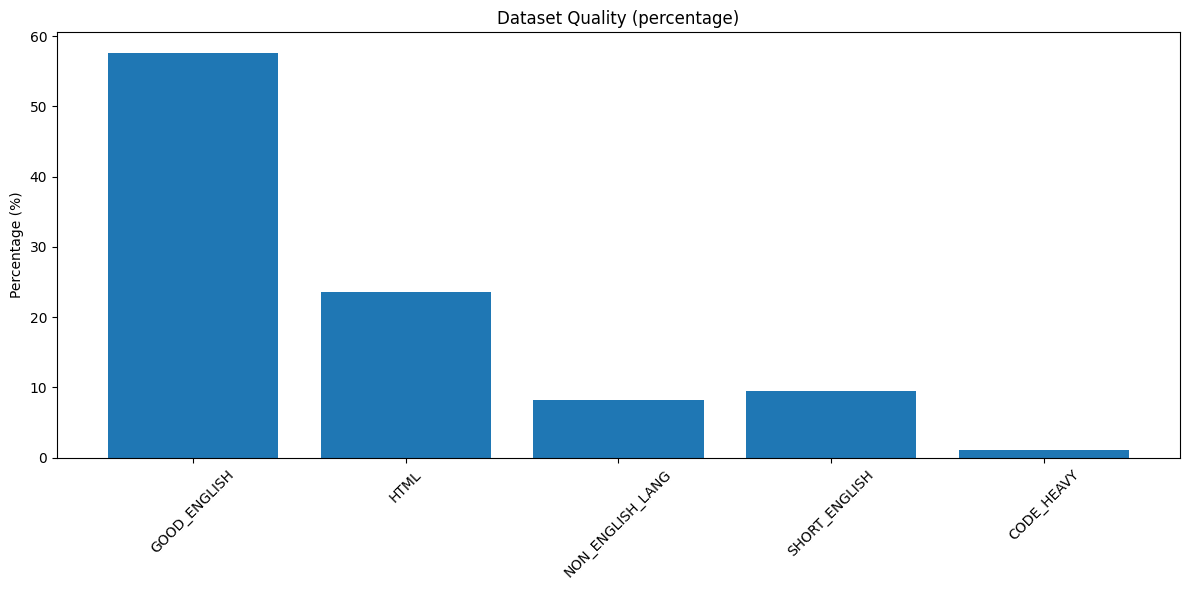

In [4]:
summary1, summary_pct1 = summarize_dataset_exclusive(raw_file, sample_size=25000)
print(summary1)
print(summary_pct1)

fig=plot_summary_percentage(summary_pct1)

#plt.savefig("../figures/summary_percentage.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Remove Duplication

In [5]:
deduplicated_file=os.path.join('../data/dedup', "mainpipe_deduplicated_data.jsonl")

dedup_exact(raw_file, deduplicated_file)

Exact dedup done: kept=220,896, dropped=48,482


# Clean dataset
clean_dataset() reads the raw dataset and produces a cleaned, English-only, normalized, non-HTML, non-code, properly sized set of documents suitable for LLM training.

- Empty / malformed filtering
- HTML removal i.e. strip html to extract text
- Language filtering: detect langugage and keep english
- Code filtering: detect code heavy docs and remove them
- Length filtering: remove too long (>50,000 chars) or too short (<200 chars ) docs 
- Applies text normalization: removes invisible Unicode junk,cleans HTML leftover spacing,flattens whitespace, trims text leading/ training white spaces
- saves cleaned data
- summarises saved and skipped documents (HTML, language, code, length, emptiness, etc.)

In [6]:
cleaned_file1=os.path.join('../data/clean', "mainpipe_clean_data2.jsonl")
c= clean_dataset(deduplicated_file,  cleaned_file1)


=== RUNNING CLEANING PIPELINE ===


220896it [06:04, 606.05it/s]


=== CLEANING FINISHED ===
KEPT: 107,320
NON_ENGLISH: 21,200
CODE_HEAVY: 72,472
HTML_STRIPPED: 53,294
TOO_SHORT: 19,622
TOO_LONG: 282



========== CLEANING SUMMARY ==========
HTML_STRIPPED  :  53294  ( 19.44%)
NON_ENGLISH    :  21200  (  7.73%)
CODE_HEAVY     :  72472  ( 26.43%)
TOO_SHORT      :  19622  (  7.16%)
TOO_LONG       :    282  (  0.10%)
KEPT           : 107320  ( 39.14%)



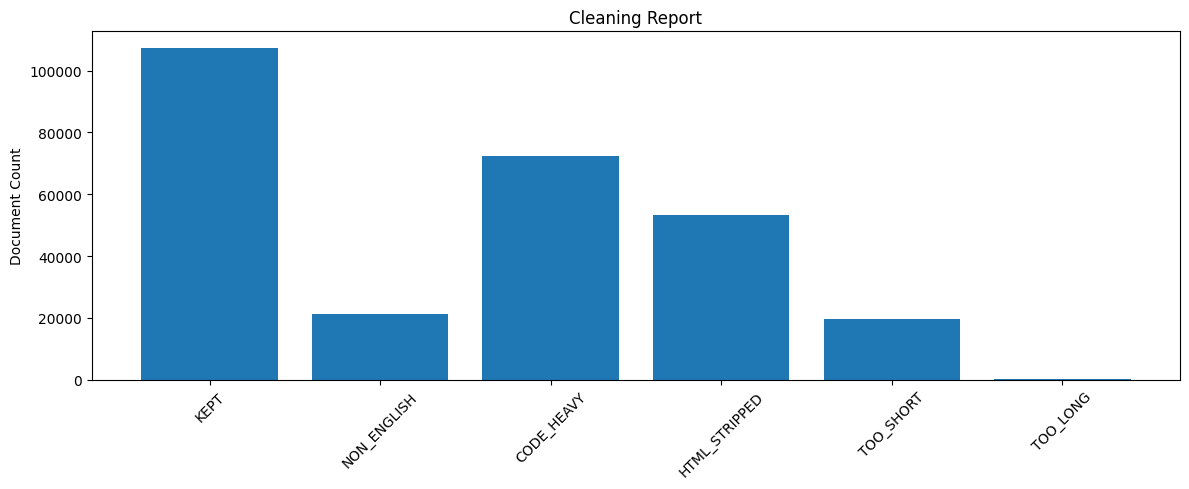

In [7]:
print_cleaning_summary(c)
fig=plot_cleaning_report(c)
fig.savefig("../figures/clean1_data_summary2.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

The raw dataset underwent a multi-stage cleaning pipeline including HTML stripping, language filtering, code detection, and length validation. 

Out of all input documents, 63.44% (173,940) were retained as high-quality English text suitable for LLM pre-training. A significant portion of the dataset (19.44%) contained HTML markup, which was successfully cleaned and partially recovered. 
Only 7.73% of documents were removed due to language mismatch, confirming that the dataset is predominantly English. Extremely code-heavy or structurally short documents contributed minor losses (0.79% and 8.50% respectively), and very long documents were rare (0.11%). 

Overall, the pipeline preserved the majority of useful content while filtering out noise, resulting in a clean, normalized corpus fit for downstream training.

### sankey diagram
Flow diagram, showing movement of quantities. Width of arrow is proportional to flows magnitude

In [8]:
# Extract values safely (if a key is missing → 0)
html       = c.get("HTML_STRIPPED", 0)
non_eng    = c.get("NON_ENGLISH", 0)
code       = c.get("CODE_HEAVY", 0)
short      = c.get("TOO_SHORT", 0)
long       = c.get("TOO_LONG", 0)
empty      = c.get("EMPTY", 0)
malformed  = c.get("MALFORMED", 0)
kept       = c.get("KEPT", 0)

total_input = sum(c.values())

# Define node labels (left → right)
labels = [
    "Raw Data",
    "HTML Present", 
    "English",
    "Filtered Out",
    "Final Kept"
]

# Sankey flow definitions
source = [
    0,  # Raw → HTML
    0,  # Raw → NON_ENGLISH
    1,  # HTML → English
    1,  # HTML → Filtered (short/long/code)
    0,  # Raw → Filtered (short/long/code)
]

target = [
    1,              # HTML
    3,              # Filtered (NON_ENGLISH)
    2,              # English
    3,              # Filtered (HTML -> too short/too long/code)
    3,              # Raw → other filters
]

value = [
    html,                       # Raw → HTML
    non_eng,                    # Raw → NON_ENGLISH
    kept,                       # HTML cleaned → English → Kept
    code + short + long,        # HTML → dropped due to filters
    code + short + long + empty + malformed,  # Raw → dropped directly
]

# Color palette for flows
colors = [
    "rgba(31,119,180,0.6)",
    "rgba(255,127,14,0.6)",
    "rgba(44,160,44,0.6)",
    "rgba(214,39,40,0.6)",
    "rgba(148,103,189,0.6)"
]

# Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
)])

fig.update_layout(
    title_text="Document Cleaning Flow (Sankey Diagram)",
    font_size=14
)
#fig.savefig("../figures/clean1_data_sankey.pdf", format="pdf", dpi=300, bbox_inches="tight")
#fig.write_image("../figures/clean1_data_sankey.pdf")
fig.show()
